In [ ]:
import numpy as np
import pandas as pd
import anndata as ad
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

import os
import sys
import logging

In [1]:
adata_rbpj = "/ocean/projects/cis240075p/asachan/datasets/B_Cell/T_cell/outs/stream_objs/rbpj_rna_imputed_v1.h5ad"
adata_ets1 = "/ocean/projects/cis240075p/asachan/datasets/B_Cell/T_cell/outs/objects/Ets1_v1.h5ad"
adata_ikzf1 = "/ocean/projects/cis240075p/asachan/datasets/B_Cell/T_cell/outs/objects/Ikzf1_v1.h5ad"
out_dir = "/ocean/projects/cis240075p/asachan/datasets/B_Cell/T_cell/outs"

In [ ]:
from os.path import basename
import stream as st
adata_rbpj_ntc = st.read(file_name=adata_rbpj, workdir=out_dir)

# import scanpy as sc
# adata_rbpj = sc.read(adata_rbpj)

/ocean/projects/cis240075p/asachan/.conda/envs/env_stream/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:17: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex


Saving results in: /ocean/projects/cis240075p/asachan/datasets/B_Cell/T_cell/outs


In [ ]:
adata_rbpj_ntc

AnnData object with n_obs × n_vars = 9072 × 2000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'RNA_snn_res.0.8', 'seurat_clusters', 'genotype', 'RNA_snn_res.0.5', 'RNA_snn_res.1', 'RNA_snn_res.1.5', 'RNA_snn_res.1.2', 'RNA_snn_res.1.8', 'RNA_snn_res.2', 'celltype5', 'cell_cluster', 'condition'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable'
    uns: 'cell_cluster_colors', 'condition_colors', 'orig.ident_colors', 'workdir'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

#### Add obs (condition and cluster label)

In [ ]:
# # the number to label mapping is the same for all TFs

# cell_type_annotation = {    "Tpex":[0,1],
#                             "Tex": [2,3],}

# cell_type_annotation_reverse = {}
# for i in set(adata_ikzf1.obs.celltype2):
#     for k in cell_type_annotation:
#         if int(i) in cell_type_annotation[k]:
#             cell_type_annotation_reverse[i] = k
# adata_ikzf1.obs["cell_cluster"] = [cell_type_annotation_reverse[i] for i in adata_ikzf1.obs.celltype2]

In [ ]:
# condition_annotation = {
#     "KO": ['S2_sgRbpj', 'S3_sgEts1', 'S4_sgEts1', 'S2_sgIkzf1', 'S4_sgIkzf1'],
#     "NTC": ['S4_sgNTC', 'S1_NTC', 'S2_NTC', 'S1_Spike', 'S3_Spike']
# }
# # Invert the dictionary
# sample_to_condition = {}
# for condition, samples in condition_annotation.items():
#     for sample in samples:
#         sample_to_condition[sample] = condition

# # Now map it to your adata object
# adata_ikzf1.obs["condition"] = adata_ikzf1.obs["orig.ident"].map(sample_to_condition)

# Run stream dim reduction

352 variable genes are selected


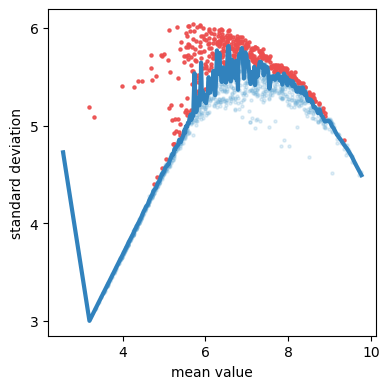

In [16]:
# # Setting var_genes if you need to select top 3k genes from a list of more than 3k genes
st.select_variable_genes(adata_rbpj_ntc,loess_frac=0.01,percentile=80)

In [17]:
# # 'var_genes' vs 'all' : use top % or all genes from .var ; if using all make sure the adata is subsetted to only the highly variable genes
# # n_components = Number of branches present in your biological differentation
st.dimension_reduction(adata_rbpj_ntc,method='se',feature='var_genes',n_components=2,n_neighbors=30,n_jobs=64) # using the same knn as diffusion maps (default is 30)

feature var_genes is being used ...
64 cpus are being used ...


In [18]:
# # Order the cell states for plotting (colors need to be categorical)
adata_rbpj_ntc.obs['cell_cluster'] = pd.Categorical(
    adata_rbpj_ntc.obs['cell_cluster'],
    categories=['Tpex', 'Tex'],
    ordered=True
)
# Create a new column in adata.obs for colors
adata_rbpj_ntc.obs['cell_cluster_colors'] = adata_rbpj_ntc.obs['cell_cluster'].map(colormap)

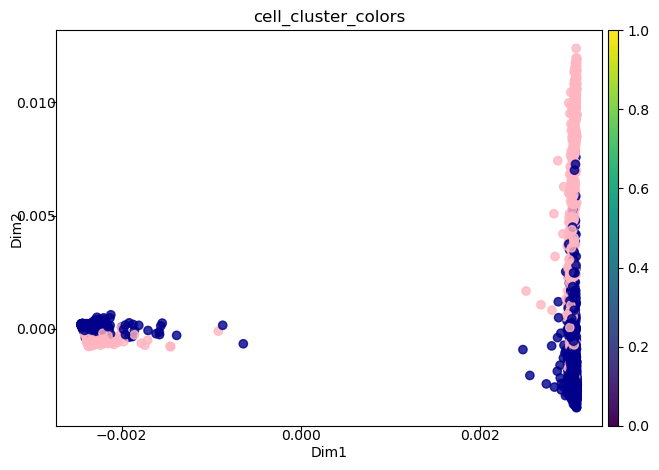

In [19]:
st.plot_dimension_reduction(adata_rbpj_ntc, color=['cell_cluster_colors'], n_components=2)

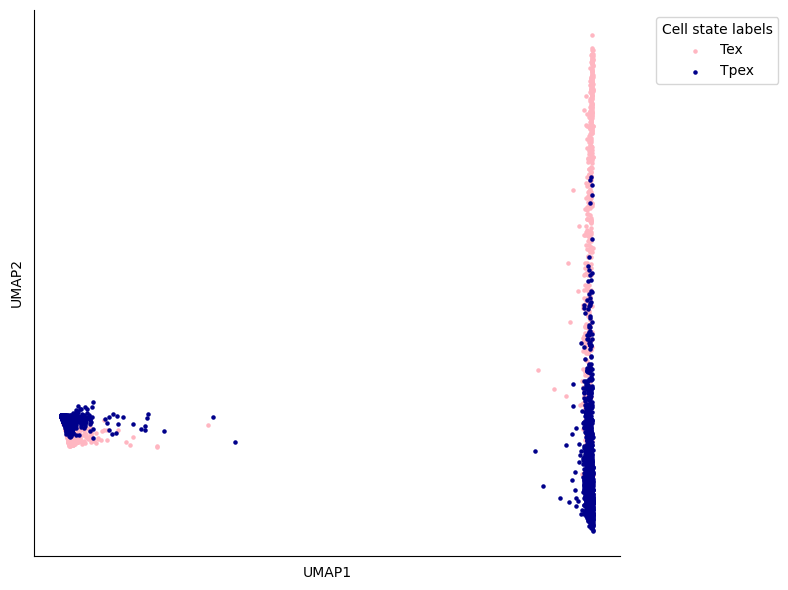

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# Extract UMAP coordinates from the 'X_dr'/'X_mlle' slot 
umap_coords = adata_rbpj_ntc.obsm['X_dr']

# Extract the labels for coloring
labels = adata_rbpj_ntc.obs['cell_cluster']

# Get unique labels and their corresponding colors
unique_labels = labels.unique()
color_list = [colormap[label] for label in unique_labels]

# Plotting the UMAP with colors based on labels
plt.figure(figsize=(8, 6))

for label, color in zip (unique_labels, color_list):
    idx = labels == label
    plt.scatter(umap_coords[idx, 0], umap_coords[idx, 1], c=color, label=label, s=5)  # s=5 sets the marker size to 5 points
# Remove ticks
plt.xticks([])
plt.yticks([])
# Remove top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.title('')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.legend(title="Cell state labels", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
# plt.savefig('/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/stream_outs/figures/bifurcation_male.pdf', 
#             bbox_inches='tight',  # Ensures the legend isn't cut off
#             dpi=300,             # High resolution
#             format='pdf')        # Specify PDF format
plt.show()

## Infer the traj by fitting elastic graph

In [21]:
import os
os.environ.pop('R_LIBS_USER', None)  # Remove custom library path
os.environ.pop('R_LIBS', None)

'/ocean/projects/cis240075p/asachan/.conda/envs/env_stream/lib/R/library'

In [22]:
from rpy2.robjects import r
r('library(rlang)')

'rlang','tools','stats','graphics',...,'utils','datasets','methods','base'


In [23]:
import os
os.environ["OMP_NUM_THREADS"] = "64"
from tempfile import TemporaryDirectory

# Parameters for STREAM (tune to your dataset)
ka1={'epg_alpha':0.02,'epg_mu':0.07,'epg_lambda':0.02,'epg_trimmingradius':2} # epg_mu needs to be tuned to get a good branch for day-1 to activated and undefined cells
ka2={'epg_ext_mode':'QuantDists','epg_ext_par':1.}

# Trajectory inference
with TemporaryDirectory() as td:
	st.set_workdir(adata_rbpj_ntc,td)
	st.seed_elastic_principal_graph(adata_rbpj_ntc,n_clusters=10)
	st.elastic_principal_graph(adata_rbpj_ntc,**ka1)
	st.extend_elastic_principal_graph(adata_rbpj_ntc,**ka2)
	

Saving results in: /tmp/tmp0w2g832p
Seeding initial elastic principal graph...
Clustering...
K-Means clustering ...
The number of initial nodes is 10
Calculatng minimum spanning tree...
Number of initial branches: 3
Learning elastic principal graph...
[1]
 "Constructing tree 1 of 1 / Subset 1 of 1"


[1]
 "Computing EPG with 50 nodes on 4772 points and 2 dimensions"


[1]
 "Using a single core"


Nodes = 
10
 
11
 
12
 
13
 
14
 
15
 
16
 
17
 
18
 
19
 
20
 
21
 
22
 
23
 
24
 
25
 
26
 
27
 
28
 
29
 
30
 
31
 
32
 
33
 
34
 
35
 
36
 
37
 
38
 
39
 
40
 
41
 
42
 
43
 
44
 
45
 
46
 
47
 
48
 
49
 


BARCODE	ENERGY	NNODES	NEDGES	NRIBS	NSTARS	NRAYS	NRAYS2	MSE	MSEP	FVE	FVEP	UE	UR	URN	URN2	URSD

1||50
	
1.89e-07
	
50
	
49
	
46
	
1
	
0
	
0
	
2.648e-08
	
2.211e-08
	
0.9982
	
0.9985
	
1.524e-07
	
1.01e-08
	
5.048e-07
	
2.524e-05
	
0




/ocean/projects/cis240075p/asachan/.conda/envs/env_stream/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang

  warnings.warn(x, RRuntimeWarning)


23.762 sec elapsed

[[1]]



Number of branches after learning elastic principal graph: 3
Extending leaves with additional nodes ...
Number of branches after extending leaves: 3


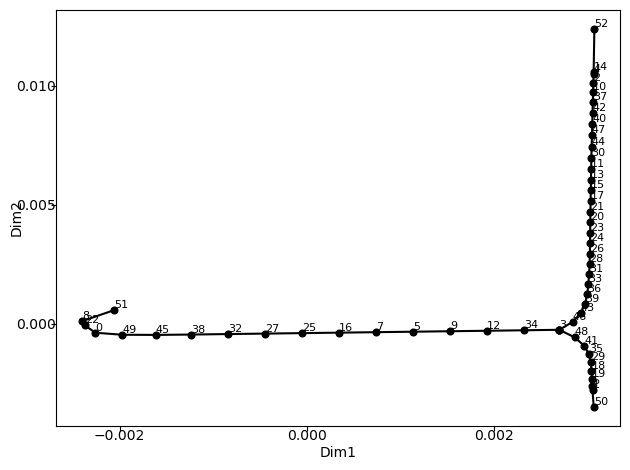

In [24]:
st.plot_branches(adata_rbpj_ntc,show_text=True, n_components=2)

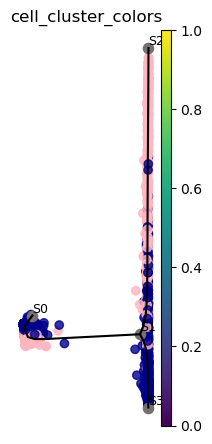

In [26]:
import matplotlib.pyplot as plt

st.plot_dimension_reduction(adata_rbpj_ntc,show_graph=True,show_text=True,color=['cell_cluster_colors'])
ax=plt.gca()
ax.set_aspect(1)
ax.axis('off');


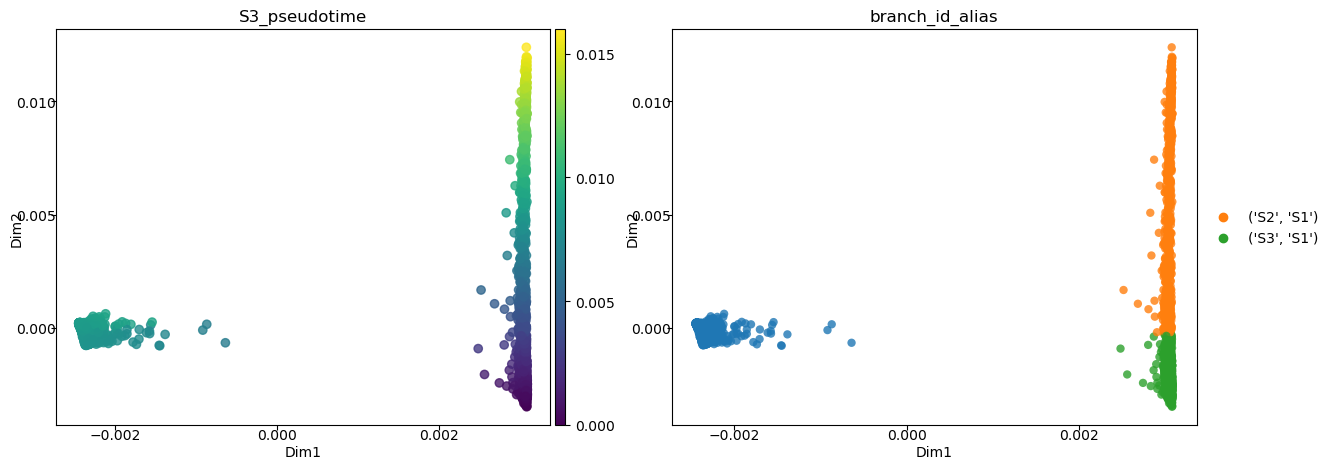

In [27]:
#Replace S3 with your own starting node if on a different dataset
st.plot_dimension_reduction(adata_rbpj_ntc,color=['S3_pseudotime','branch_id_alias'])

In [29]:
# write adata_rbpj_ntc to a file
st.write(adata_rbpj_ntc, file_name='/ocean/projects/cis240075p/asachan/datasets/B_Cell/T_cell/outs/stream_objs/rbpj_ntc.pkl')